<a href="https://colab.research.google.com/github/chvamshi/Deep-Steganography/blob/main/LOSS1_DS_img_crop_10_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip && ls tiny-imagenet-200

--2022-02-03 18:27:56--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  77.0MB/s    in 3.1s    

2022-02-03 18:27:59 (77.0 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]

test  train  val  wnids.txt  words.txt


In [ ]:
# Imports necessary libraries and modules
from itertools import islice
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import Variable
from torch import utils
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os 
from pathlib import Path
import pickle
import random
from torchvision import datasets, utils
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
from torchvision.transforms import RandomResizedCrop
from torchvision.transforms.functional import resized_crop
from random import shuffle
from IPython.display import Image
from PIL import Image

# Use GPU if it is present
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# Directory path
# os.chdir("..")
cwd = '/content/tiny-imagenet-200'

# Hyper Parameters
num_epochs = 50
batch_size = 32
learning_rate = 0.001
beta = 1

# Mean and std deviation of imagenet dataset. Source: http://cs231n.stanford.edu/reports/2017/pdfs/101.pdf
std = [0.229, 0.224, 0.225]
mean = [0.485, 0.456, 0.406]

# TODO: Define train, validation and models
MODELS_PATH = '/content/output/models'
# TRAIN_PATH = cwd+'/train/'
# VALID_PATH = cwd+'/valid/'
VALID_PATH = cwd+'/val/'
TRAIN_PATH = cwd+'/train/'
TEST_PATH = cwd+'/test/'

# if not os.path.exists(MODELS_PATH): os.mkdir(MODELS_PATH)

In [ ]:
def variance(image1, image2):
    var1 = torch.var(image1)
    var2 = torch.var(image2)

    return var1+var2

def customized_loss(S_prime, C_prime, S, C, B):
    ''' Calculates loss specified on the paper.'''
    
    loss_cover = torch.nn.functional.l1_loss(C_prime, C)
    loss_cover = loss_cover/(64*64)
    loss_secret = torch.nn.functional.l1_loss(S_prime, S)
    loss_secret = loss_secret/(64*64)

    variance_cover = variance(C_prime, C)
    variance_secret = variance(S_prime, S)

    loss_all = loss_cover+loss_secret+variance_cover+variance_secret
    loss_all = loss_all/4

    return loss_all, loss_cover, loss_secret

def denormalize(image, std, mean):
    ''' Denormalizes a tensor of images.'''

    for t in range(3):
        image[t, :, :] = (image[t, :, :] * std[t]) + mean[t]
    return image

def imshow(img, idx, learning_rate, beta):
    '''Prints out an image given in tensor format.'''
    
    img = denormalize(img, std, mean)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title('Example '+str(idx)+', lr='+str(learning_rate)+', B='+str(beta))
    plt.show()
    return

def gaussian(tensor, mean=0, stddev=0.1):
    '''Adds random noise to a tensor.'''
    
    noise = torch.nn.init.normal(torch.Tensor(tensor.size()), 0, 0.1).to(device)
    return Variable(tensor + noise)

def tensor_to_image(tensor):
    """
    Transforms a torch tensor into numpy uint8 array (image)
    :param tensor: (batch_size x channels x height x width) torch tensor in range [-1.0, 1.0]
    :return: (batch_size x height x width x channels) uint8 array
    """
    image = tensor.cpu().numpy()[0]
    # image = tensor.permute(0, 2, 3, 1).cpu().numpy()
    image = np.transpose(image, (1,2,0))
    image = (image + 1) * 127.5
    return np.clip(image, 0, 255).astype(np.uint8)

In [ ]:
import torch.nn as nn
import numpy as np

def random_float(min, max):
    """
    Return a random number
    :param min:
    :param max:
    :return:
    """
    return np.random.rand() * (max - min) + min


def get_random_rectangle_inside(image, height_ratio_range, width_ratio_range):
    """
    Returns a random rectangle inside the image, where the size is random and is controlled by height_ratio_range and width_ratio_range.
    This is analogous to a random crop. For example, if height_ratio_range is (0.7, 0.9), then a random number in that range will be chosen
    (say it is 0.75 for illustration), and the image will be cropped such that the remaining height equals 0.75. In fact,
    a random 'starting' position rs will be chosen from (0, 0.25), and the crop will start at rs and end at rs + 0.75. This ensures
    that we crop from top/bottom with equal probability.
    The same logic applies to the width of the image, where width_ratio_range controls the width crop range.
    :param image: The image we want to crop
    :param height_ratio_range: The range of remaining height ratio
    :param width_ratio_range:  The range of remaining width ratio.
    :return: "Cropped" rectange with width and height drawn randomly height_ratio_range and width_ratio_range
    """
    # print(image.shape)
    image_height = image.shape[1]
    image_width = image.shape[2]

    remaining_height = int(np.rint(random_float(height_ratio_range[0], height_ratio_range[1]) * image_height))
    remaining_width = int(np.rint(random_float(width_ratio_range[0], width_ratio_range[0]) * image_width))

    if remaining_height == image_height:
        height_start = 0
    else:
        height_start = np.random.randint(0, image_height - remaining_height)

    if remaining_width == image_width:
        width_start = 0
    else:
        width_start = np.random.randint(0, image_width - remaining_width)

    return height_start, height_start+remaining_height, width_start, width_start+remaining_width


class Crop(nn.Module):
    """
    Randomly crops the image from top/bottom and left/right. The amount to crop is controlled by parameters
    heigth_ratio_range and width_ratio_range
    """
    def __init__(self, height_ratio_range, width_ratio_range):
        """
        :param height_ratio_range:
        :param width_ratio_range:
        """
        super(Crop, self).__init__()
        self.height_ratio_range = height_ratio_range
        self.width_ratio_range = width_ratio_range


    def forward(self, noised_and_cover):
        noised_image = noised_and_cover[0]
        print("Noisedimageshape: ",noised_image.shape)
        shape = noised_image.shape
        # crop_rectangle is in form (from, to) where @from and @to are 2D points -- (height, width)

        h_start, h_end, w_start, w_end = get_random_rectangle_inside(noised_image, self.height_ratio_range, self.width_ratio_range)

        noised_image =  noised_image[
               :,
               h_start: h_end,
               w_start: w_end].clone()
        noised_image1 = noised_image.expand(-1,64,64)
        print(noised_image1.shape)
        noised_and_cover[0] = noised_image1.clone()

        return noised_and_cover

In [ ]:
# Preparation Network (2 conv layers)
class PrepNetwork(nn.Module):
    def __init__(self):
        super(PrepNetwork, self).__init__()
        self.initialP3 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.initialP4 = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(10, 10, kernel_size=4, padding=2),
            nn.ReLU())
        self.initialP5 = nn.Sequential(
            nn.Conv2d(3, 5, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(5, 5, kernel_size=5, padding=2),
            nn.ReLU())
        self.finalP3 = nn.Sequential(
            nn.Conv2d(65, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.finalP4 = nn.Sequential(
            nn.Conv2d(65, 10, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(10, 10, kernel_size=4, padding=2),
            nn.ReLU())
        self.finalP5 = nn.Sequential(
            nn.Conv2d(65, 5, kernel_size=5, padding=2),
            nn.ReLU())

    def forward(self, p):
        p1 = self.initialP3(p)
        p2 = self.initialP4(p)
        p3 = self.initialP5(p)
        mid = torch.cat((p1, p2, p3), 1)
        p4 = self.finalP3(mid)
        p5 = self.finalP4(mid)
        p6 = self.finalP5(mid)
        # print(p4.shape)
        # print(p5.shape)
        # print(p6.shape)
        out = torch.cat((p4, p5, p6), 1)
        return out

# Hiding Network (5 conv layers)
class HidingNetwork(nn.Module):
    def __init__(self):
        super(HidingNetwork, self).__init__()
        self.initialH3 = nn.Sequential(
            nn.Conv2d(68, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.initialH4 = nn.Sequential(
            nn.Conv2d(68, 10, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(10, 10, kernel_size=4, padding=2),
            nn.ReLU(),
            nn.Conv2d(10, 10, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(10, 10, kernel_size=4, padding=2),
            nn.ReLU())
        self.initialH5 = nn.Sequential(
            nn.Conv2d(68, 5, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(5, 5, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(5, 5, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(5, 5, kernel_size=5, padding=2),
            nn.ReLU())
        self.finalH3 = nn.Sequential(
            nn.Conv2d(65, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.finalH4 = nn.Sequential(
            nn.Conv2d(65, 10, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(10, 10, kernel_size=4, padding=2),
            nn.ReLU())
        self.finalH5 = nn.Sequential(
            nn.Conv2d(65, 5, kernel_size=5, padding=2),
            nn.ReLU())
        self.finalH = nn.Sequential(
            nn.Conv2d(65, 3, kernel_size=1, padding=0))
        
    def forward(self, h):
        h1 = self.initialH3(h)
        h2 = self.initialH4(h)
        h3 = self.initialH5(h)
        mid = torch.cat((h1, h2, h3), 1)
        h4 = self.finalH3(mid)
        h5 = self.finalH4(mid)
        h6 = self.finalH5(mid)
        mid2 = torch.cat((h4, h5, h6), 1)
        out = self.finalH(mid2)
        out_noise = gaussian(out.data, 0, 0.1)
        return out, out_noise

# Reveal Network (2 conv layers)
class RevealNetwork(nn.Module):
    def __init__(self):
        super(RevealNetwork, self).__init__()
        self.initialR3 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.initialR4 = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(10, 10, kernel_size=4, padding=2),
            nn.ReLU(),
            nn.Conv2d(10, 10, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(10, 10, kernel_size=4, padding=2),
            nn.ReLU())
        self.initialR5 = nn.Sequential(
            nn.Conv2d(3, 5, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(5, 5, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(5, 5, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(5, 5, kernel_size=5, padding=2),
            nn.ReLU())
        self.finalR3 = nn.Sequential(
            nn.Conv2d(65, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.finalR4 = nn.Sequential(
            nn.Conv2d(65, 10, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(10, 10, kernel_size=4, padding=2),
            nn.ReLU())
        self.finalR5 = nn.Sequential(
            nn.Conv2d(65, 5, kernel_size=5, padding=2),
            nn.ReLU())
        self.finalR = nn.Sequential(
            nn.Conv2d(65, 3, kernel_size=1, padding=0))

    def forward(self, r, img_shape):
        # r = r.expand(img_shape)
        r1 = self.initialR3(r)
        r2 = self.initialR4(r)
        r3 = self.initialR5(r)
        mid = torch.cat((r1, r2, r3), 1)
        r4 = self.finalR3(mid)
        r5 = self.finalR4(mid)
        r6 = self.finalR5(mid)
        mid2 = torch.cat((r4, r5, r6), 1)
        out = self.finalR(mid2)
        return out

# Join three networks in one module
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.m1 = PrepNetwork().to(device)
        self.m2 = HidingNetwork().to(device)
        self.m3 = RevealNetwork().to(device)
        self.crop = Crop((0.7,0.9),(0.7,0.9)).to(device)

    def forward(self, secret, cover):
        img_shape = secret.shape
        x_1 = self.m1(secret)
        mid = torch.cat((x_1, cover), 1)
        x_2, x_2_noise = self.m2(mid)
        # x_2_noise = resized_crop(img=x_2_noise, top = 0, left=0, height=19, width=19, size=[64,64])
        x_2 =  resized_crop(img=x_2, top = 0, left=0, height=7, width=7, size=[64,64])
        # x_3 = self.m3(x_2_noise, img_shape)
        x_3 = self.m3(x_2, img_shape)
        return x_2, x_3 

In [ ]:
# Creates net object
net = Net().to(device)

In [ ]:
# Creates training set
train_data = datasets.ImageFolder(
        TRAIN_PATH,
        transforms.Compose([
        # transforms.Scale(256),
        # transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,
        std=std)
        ]))
train_data = Subset(train_data, [i for i in range(32000)])
train_loader = torch.utils.data.DataLoader(
        train_data, batch_size=batch_size, num_workers=1, 
        pin_memory=True, shuffle=True, drop_last=True)

# Creates test set
test_data = datasets.ImageFolder(
        TEST_PATH, 
        transforms.Compose([
        # transforms.Scale(256),
        # transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,
        std=std)
        ]))
test_data = Subset(test_data,[i for i in range(5000)])
test_loader = torch.utils.data.DataLoader(
        test_data, batch_size=2, num_workers=1, 
        pin_memory=True, shuffle=True, drop_last=True)

In [ ]:
PATH = "/content/drive/MyDrive/"
loss_history = []

def train_model(train_loader, beta, learning_rate):
    
    # Save optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    loss_history = []
    # Iterate over batches performing forward and backward passes
    for epoch in range(num_epochs):

        # Train mode
        net.train()
        
        train_losses = []
        # Train one epoch
        for idx, train_batch in enumerate(train_loader):

            data, _  = train_batch
            data = data.to(device)

            # Saves secret images and secret covers
            train_covers = data[:len(data)//2]
            train_secrets = data[len(data)//2:]
            
            # Creates variable from secret and cover images
            train_secrets = Variable(train_secrets, requires_grad=False)
            train_covers = Variable(train_covers, requires_grad=False)

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            train_hidden, train_output = net(train_secrets, train_covers)

            # Calculate loss and perform backprop
            train_loss, train_loss_cover, train_loss_secret = customized_loss(train_output, train_hidden, train_secrets, train_covers, beta)
            train_loss.backward()
            optimizer.step()
            
            # Saves training loss
            # print(train_loss.data)
            train_losses.append(train_loss.data.item())
            loss_history.append(train_loss.data.item())
            
            # Prints mini-batch losses
            print('Training: Batch {0}/{1}. Loss of {2:.4f}, cover loss of {3:.4f}, secret loss of {4:.4f}'.format(idx+1, len(train_loader), train_loss.data.item(), train_loss_cover.data.item(), train_loss_secret.data.item()))
    
        # Save model
        # torch.save(net.state_dict(), '/content/Epoch N{}.pkl'.format(epoch+1))
        torch.save(net.state_dict(), PATH+"LOSS1_ds_crop_10.pth")
        with open(PATH+"LOSS1_loss_history_crop_10.txt", "a") as f:
            for s in loss_history:
                f.write(str(s) +"\n")
        
        mean_train_loss = np.mean(train_losses)
    
        # Prints epoch average loss
        print ('Epoch [{0}/{1}], Average_loss: {2:.4f}'.format(
                epoch+1, num_epochs, mean_train_loss))
    
    return net, mean_train_loss, loss_history

In [ ]:
# Load model
# net.load_state_dict(torch.load(PATH+"LOSS1_ds_crop_10.pth"))
# loss_history = []
# with open(PATH+"LOSS1_loss_history_crop_10.txt", "r") as f:
#   for line in f:
#     loss_history.append(float(line.strip()))

net, mean_train_loss, loss_history = train_model(train_loader, beta, learning_rate)
# loss_history.extend(loss_history1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


Streaming output truncated to the last 5000 lines.
Training: Batch 6/1000. Loss of 0.6067, cover loss of 0.0002, secret loss of 0.0002
Training: Batch 7/1000. Loss of 0.6473, cover loss of 0.0003, secret loss of 0.0002
Training: Batch 8/1000. Loss of 0.7223, cover loss of 0.0002, secret loss of 0.0003
Training: Batch 9/1000. Loss of 0.7397, cover loss of 0.0003, secret loss of 0.0002
Training: Batch 10/1000. Loss of 0.7679, cover loss of 0.0003, secret loss of 0.0002
Training: Batch 11/1000. Loss of 0.6083, cover loss of 0.0002, secret loss of 0.0002
Training: Batch 12/1000. Loss of 0.7000, cover loss of 0.0003, secret loss of 0.0002
Training: Batch 13/1000. Loss of 0.6884, cover loss of 0.0002, secret loss of 0.0003
Training: Batch 14/1000. Loss of 0.6752, cover loss of 0.0002, secret loss of 0.0003
Training: Batch 15/1000. Loss of 0.6618, cover loss of 0.0002, secret loss of 0.0002
Training: Batch 16/1000. Loss of 0.6956, cover loss of 0.0003, secret loss of 0.0002
Training: Batch 17

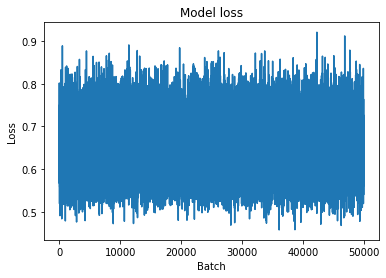

In [ ]:
 # Plot loss through epochs
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Batch')
plt.show()

In [ ]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    input_S = np.array(input_S.detach().cpu())
    input_C = np.array(input_C.detach().cpu())
    decoded_S = np.array(decoded_S.detach().cpu())
    decoded_C = np.array(decoded_C.detach().cpu())
    # print(input_S)
    see_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))
    
    return see_Spixel, see_Cpixel

import math
def psnr(input_S, input_C, decoded_S, decoded_C):
    input_S = np.array(input_S.detach().cpu())
    input_C = np.array(input_C.detach().cpu())
    decoded_S = np.array(decoded_S.detach().cpu())
    decoded_C = np.array(decoded_C.detach().cpu())
    mse_s = np.mean(np.square(255*(input_S - decoded_S)))
    mse_c = np.mean(np.square(255*(input_C - decoded_C)))
    psnr_s = 10*math.log10(255**2/mse_s)
    psnr_c = 10*math.log10(255**2/mse_c)
    return psnr_s, psnr_c

def pixel_histogram(diff_S, diff_C):
    """Calculates histograms of errors for cover and secret image. """
    diff_Sflat = diff_S.flatten()
    diff_Cflat = diff_C.flatten()
    
    fig = plt.figure(figsize=(15, 5))
    a=fig.add_subplot(1,2,1)
        
    imgplot = plt.hist(255* diff_Cflat, 100, density=1, alpha=0.75, facecolor='red')
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])
    
    a=fig.add_subplot(1,2,2)
    imgplot = plt.hist(255* diff_Sflat, 100, density=1, alpha=0.75, facecolor='red')
    a.set_title('Distribution of errors in the Secret image.')
    plt.axis([0, 250, 0, 0.2])
    
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


Total loss: 0.37 
Loss on secret: 0.00 
Loss on cover: 0.00


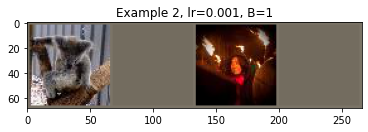

Total loss: 0.65 
Loss on secret: 0.00 
Loss on cover: 0.00


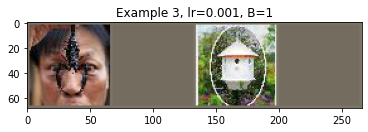

Total loss: 0.76 
Loss on secret: 0.00 
Loss on cover: 0.00


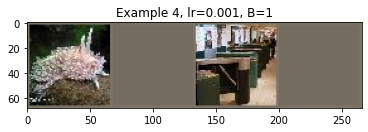

Total loss: 0.92 
Loss on secret: 0.00 
Loss on cover: 0.00


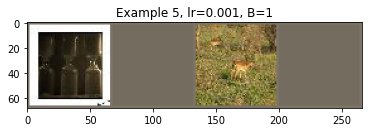

Average loss on test set: 0.59


In [ ]:
# net.load_state_dict(torch.load(MODELS_PATH+'Epoch N4.pkl'))

# Switch to evaluate mode
net.eval()
Path(PATH+"LOSS1_ds_img_10").mkdir(parents=True, exist_ok=True)
Path(PATH+"LOSS1_ds_img_10/cover_images/").mkdir(parents=True, exist_ok=True)
Path(PATH+"LOSS1_ds_img_10/container_images/").mkdir(parents=True, exist_ok=True)
save_path = PATH+"LOSS1_ds_img_10/"

test_losses = []

S_errors = []
C_errors = []

psnr_s,psnr_c = [], []
# Show images
for idx, test_batch in enumerate(test_loader):
     # Saves images
    data, _ = test_batch
    data = data.to(device)

    # Saves secret images and secret covers
    test_secret = data[:len(data)//2]
    test_cover = data[len(data)//2:]

    # Creates variable from secret and cover images
    test_secret = Variable(test_secret, volatile=True)
    test_cover = Variable(test_cover, volatile=True)

    # Compute output
    test_hidden, test_output = net(test_secret, test_cover)
    
    # Calculate loss
    test_loss, loss_cover, loss_secret = customized_loss(test_output, test_hidden, test_secret, test_cover, beta)
    
    diff_S, diff_C = np.abs(np.array(test_output.data.detach().cpu()) - np.array(test_secret.data.detach().cpu())), np.abs(np.array(test_hidden.data.detach().cpu()) - np.array(test_cover.data.detach().cpu()))
    
#     print (diff_S, diff_C)

    # Print pixel-wise average errors in a 256 scale.
    S_error, C_error = pixel_errors(test_secret, test_cover, test_output, test_hidden)
    S_errors.append(S_error)
    C_errors.append(C_error)

    S_psnr, C_psnr = psnr(test_secret, test_cover, test_output, test_hidden)
    psnr_s.append(S_psnr)
    psnr_c.append(C_psnr)
    
    if idx in [1,2,3,4]:
        print ('Total loss: {:.2f} \nLoss on secret: {:.2f} \nLoss on cover: {:.2f}'.format(test_loss.data.item(), loss_secret.data.item(), loss_cover.data.item()))

        # Creates img tensor
        imgs = [test_secret.data.detach().cpu(), test_output.data.detach().cpu(), test_cover.data.detach().cpu(), test_hidden.data.detach().cpu()]
        imgs_tsor = torch.cat(imgs, 0)

        # Prints Images
        imshow(utils.make_grid(imgs_tsor), idx+1, learning_rate=learning_rate, beta=beta)

    if idx < 500:
        container_img = tensor_to_image(test_hidden.data.detach().cpu())
        container_img = Image.fromarray(container_img)
        container_img.save(save_path+"container_images/"+str(idx)+".jpeg")
        cover_img = tensor_to_image(test_cover.data.detach().cpu())
        cover_img = Image.fromarray(cover_img)
        cover_img.save(save_path+"cover_images/"+str(idx)+".jpeg")
            
    test_losses.append(test_loss.data.item())
        
mean_test_loss = np.mean(test_losses)

print ('Average loss on test set: {:.2f}'.format(mean_test_loss))

In [19]:
print ("Avg. S error per pixel [0, 255]:", sum(S_errors)/len(S_errors))
print ("Avg. C error per pixel [0, 255]:", sum(C_errors)/len(C_errors))

Avg. S error per pixel [0, 255]: 304.4830888671875
Avg. C error per pixel [0, 255]: 300.7385453582764


In [20]:
print ("Avg. PSNR of secret and decoded secret:", sum(psnr_s)/len(psnr_s))
print ("Avg. PSNR of cover and container:", sum(psnr_c)/len(psnr_c))

Avg. PSNR of secret and decoded secret: -1.333798551578633
Avg. PSNR of cover and container: -1.209784764472752


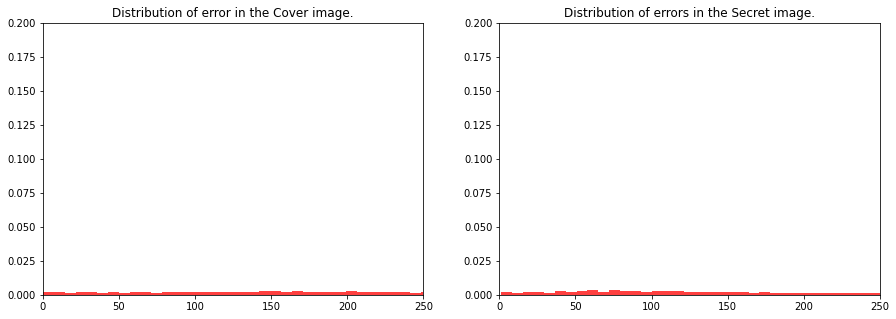

In [21]:
# Plot distribution of errors in cover and secret images.
pixel_histogram(diff_S, diff_C)